# STEP 1: SETUP AND DATA LOADING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('heart_stroke_data.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# STEP 2: DATA EXPLORATION

Missing values:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Stroke distribution:
 stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


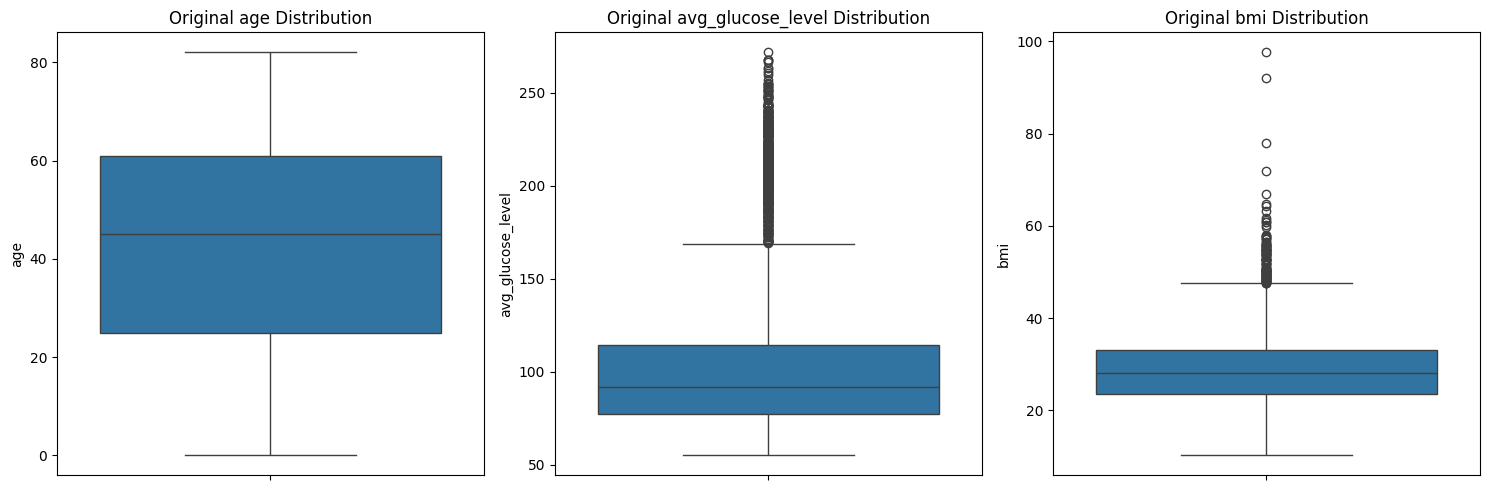

In [2]:
# Check missing values
print("Missing values:\n", df.isnull().sum())

# Check class distribution
print("\nStroke distribution:\n", df['stroke'].value_counts(normalize=True))

# Visualize numerical features
numerical_features = ['age', 'avg_glucose_level', 'bmi']
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Original {col} Distribution')
plt.tight_layout()
plt.show()

# STEP 3: COMPREHENSIVE OUTLIER HANDLING

Outlier Removal Report:

age:
 - Bounds: [-83.00, 169.00]
 - Outliers removed: 0
 - Remaining outliers (stroke cases): 0

avg_glucose_level:
 - Bounds: [-33.29, 224.62]
 - Outliers removed: 144
 - Remaining outliers (stroke cases): 22

bmi:
 - Bounds: [-4.70, 61.10]
 - Outliers removed: 10
 - Remaining outliers (stroke cases): 0


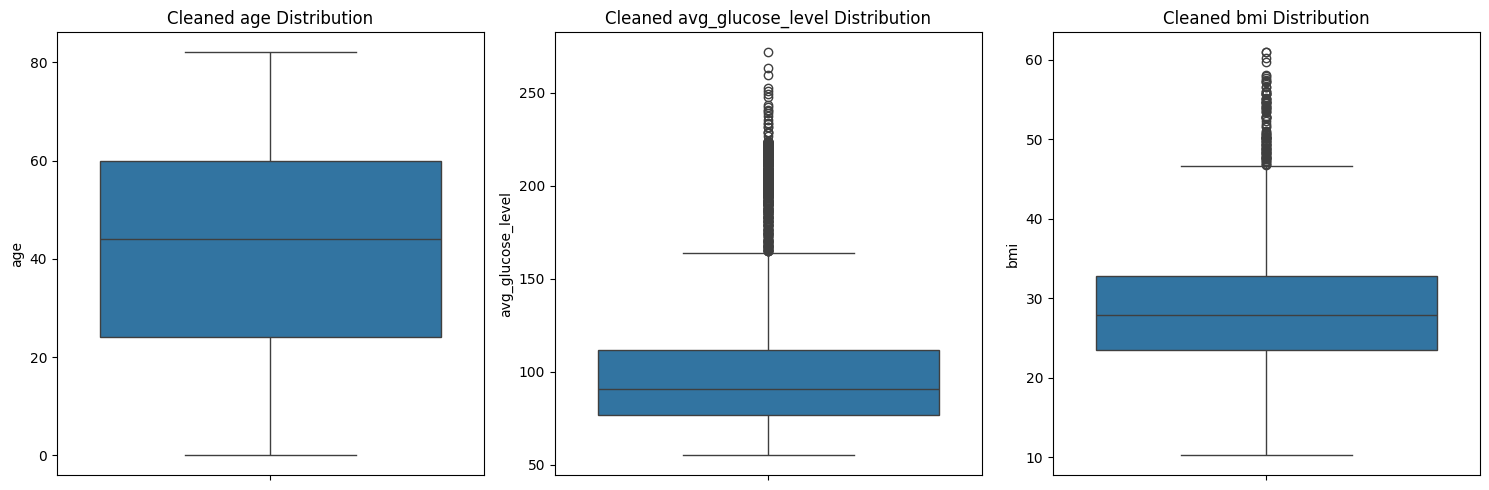


Original dataset size: 5110
Cleaned dataset size: 4807 (94.1% retained)


In [3]:
def remove_outliers(df, features):
    """
    Remove outliers beyond 3*IQR while preserving stroke cases
    Returns cleaned dataframe and outlier report
    """
    outlier_report = {}
    df_clean = df.copy()
    
    for col in features:
        # Calculate bounds
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 3*iqr  # Using 3*IQR for more conservative outlier removal
        upper = q3 + 3*iqr
        
        # Count outliers
        n_outliers = len(df_clean[(df_clean[col] < lower) | (df_clean[col] > upper)])
        
        # Remove outliers (keep stroke cases regardless)
        condition = ((df_clean[col] >= lower) & (df_clean[col] <= upper) | (df_clean['stroke'] == 1))
        df_clean = df_clean[condition]
        
        outlier_report[col] = {
            'lower_bound': lower,
            'upper_bound': upper,
            'outliers_removed': n_outliers - len(df_clean[(df_clean[col] < lower) | (df_clean[col] > upper)]),
            'remaining_outliers': len(df_clean[(df_clean[col] < lower) | (df_clean[col] > upper)])
        }
    
    return df_clean, outlier_report

# Apply outlier removal
df_clean, outlier_report = remove_outliers(df, numerical_features)

# Print outlier report
print("Outlier Removal Report:")
for col, report in outlier_report.items():
    print(f"\n{col}:")
    print(f" - Bounds: [{report['lower_bound']:.2f}, {report['upper_bound']:.2f}]")
    print(f" - Outliers removed: {report['outliers_removed']}")
    print(f" - Remaining outliers (stroke cases): {report['remaining_outliers']}")

# Visualize cleaned data
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df_clean[col])
    plt.title(f'Cleaned {col} Distribution')
plt.tight_layout()
plt.show()

print(f"\nOriginal dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_clean)} ({len(df_clean)/len(df):.1%} retained)")

# STEP 4: DATA PREPROCESSING

In [4]:
# Drop ID column
df_clean = df_clean.drop(columns=['id'])

# Define features and target
X = df_clean.drop(columns=['stroke'])
y = df_clean['stroke']

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                       'work_type', 'Residence_type', 'smoking_status']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# STEP 5 : HANDLE CLASS IMBALANCE WITH SMOTE

In [5]:
# Method 1: Proper way to check class distribution with SMOTE in pipeline
print("Class distribution before SMOTE:", np.bincount(y_train))

# Create and fit the entire pipeline
smote_pipeline = make_imb_pipeline(
    preprocessor,
    SMOTE(random_state=42, sampling_strategy='minority'),
    RandomForestClassifier(random_state=42)
)

# Fit the pipeline (this will fit all steps including the preprocessor)
smote_pipeline.fit(X_train, y_train)

# Method to verify SMOTE worked correctly:
# Get the SMOTE step from the fitted pipeline
fitted_smote = smote_pipeline.named_steps['smote']

# Get the resampled data by accessing the pipeline's named steps
preprocessor = smote_pipeline.named_steps['columntransformer']
classifier = smote_pipeline.named_steps['randomforestclassifier']

# Transform the training data (this uses the fitted preprocessor)
X_train_preprocessed = preprocessor.transform(X_train)

# Apply the fitted SMOTE to get resampled data
X_train_res, y_train_res = fitted_smote.fit_resample(X_train_preprocessed, y_train)

print("Class distribution after SMOTE:", np.bincount(y_train_res))
print("\nPipeline verification:")
print(f"Original training samples: {len(X_train)}")
print(f"Resampled training samples: {len(X_train_res)}")
print("Pipeline fitted successfully!")

# Alternative verification method:
# Count samples by class in the trained classifier
if hasattr(classifier, 'classes_'):
    print("\nClassifier class distribution:")
    print(dict(zip(classifier.classes_, np.bincount(classifier.classes_))))

Class distribution before SMOTE: [3646  199]
Class distribution after SMOTE: [3646 3646]

Pipeline verification:
Original training samples: 3845
Resampled training samples: 7292
Pipeline fitted successfully!

Classifier class distribution:
{np.int64(0): np.int64(1), np.int64(1): np.int64(1)}


# STEP 6: BASELINE MODEL TRAINING

In [6]:
# Baseline pipeline without SMOTE for comparison
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train and evaluate
baseline_pipeline.fit(X_train, y_train)
y_pred = baseline_pipeline.predict(X_test)
y_proba = baseline_pipeline.predict_proba(X_test)[:, 1]

print("BASELINE MODEL PERFORMANCE:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

BASELINE MODEL PERFORMANCE:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       912
           1       0.50      0.06      0.11        50

    accuracy                           0.95       962
   macro avg       0.73      0.53      0.54       962
weighted avg       0.93      0.95      0.93       962

ROC AUC: 0.7966
Confusion Matrix:
 [[909   3]
 [ 47   3]]


# STEP 7 : HYPERPARAMETER TUNING

In [7]:
# Need to use imblearn's Pipeline instead of sklearn's
from imblearn.pipeline import Pipeline as imbPipeline

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': ['balanced', None]
}

# Create imblearn pipeline (NOT sklearn pipeline)
model_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the model (this will now work)
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed!")

# Best model
best_model = grid_search.best_estimator_
print("\nBEST PARAMETERS:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)

Starting grid search...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Grid search completed!

BEST PARAMETERS: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best ROC AUC score: 0.8245283218610874


# STEP 8: EVALUATE FINAL MODEL

In [9]:
from sklearn.metrics import accuracy_score

# Get predictions
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

Model Accuracy: 91.58%

Confusion Matrix:
[[874  38]
 [ 43   7]]


TUNED MODEL PERFORMANCE:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       912
           1       0.16      0.14      0.15        50

    accuracy                           0.92       962
   macro avg       0.55      0.55      0.55       962
weighted avg       0.91      0.92      0.91       962

ROC AUC: 0.8108
Confusion Matrix:
 [[874  38]
 [ 43   7]]


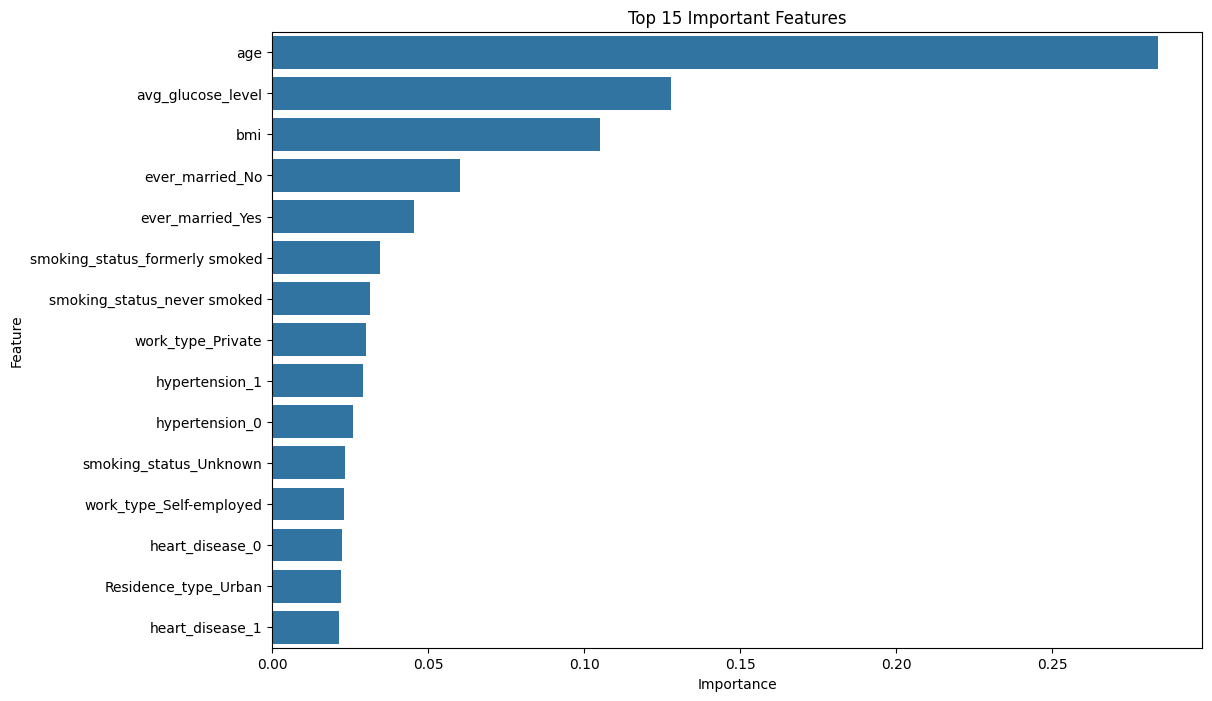

In [8]:
# Predictions
y_pred_tuned = best_model.predict(X_test)
y_proba_tuned = best_model.predict_proba(X_test)[:, 1]

# Evaluation
print("TUNED MODEL PERFORMANCE:")
print(classification_report(y_test, y_pred_tuned))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_tuned):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

# Feature Importance
feature_names = numerical_features + list(
    best_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)

importances = best_model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Important Features')
plt.show()

# STEP 9: PREDICTION FUNCTION

In [12]:
def predict_stroke_risk(patient_data):
    """
    Predicts stroke risk probability (0-1)
    
    Args:
        patient_data (dict): Dictionary containing patient features
        
    Returns:
        dict: Prediction results with probability and interpretation
    """
    # Convert to DataFrame
    patient_df = pd.DataFrame([patient_data])
    
    # Predict probability
    proba = best_model.predict_proba(patient_df)[0, 1]
    
    # Interpretation
    if proba >= 0.7:
        risk = "High"
    elif proba >= 0.4:
        risk = "Medium"
    else:
        risk = "Low"
    
    return {
        'probability': float(proba),
        'risk_level': risk,
        'interpretation': f"This patient has a {risk.lower()} risk of stroke ({proba:.1%})"
    }

# Example usage
example_patient = {
    'gender': 'Male',
    'age': 58,
    'hypertension': 1,
    'heart_disease': 0,
    'ever_married': 'Yes',
    'work_type': 'Govt_job',
    'Residence_type': 'Rural',
    'avg_glucose_level': 56.96,
    'bmi': 26.8,
    'smoking_status': 'smokes'
}

result = predict_stroke_risk(example_patient)
print("\nPREDICTION RESULT:")
for key, value in result.items():
    print(f"{key.replace('_', ' ').title()}: {value}")


PREDICTION RESULT:
Probability: 0.3186146323797938
Risk Level: Low
Interpretation: This patient has a low risk of stroke (31.9%)


Dataset shape: (5110, 12)
Class distribution before SMOTE: [3889  199]
Pipeline fitted successfully!
Starting grid search...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Grid search completed!

BEST PARAMETERS: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best ROC AUC score: 0.8734928245093675

FINAL MODEL PERFORMANCE:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       972
           1       0.26      0.56      0.35        50

    accuracy                           0.90      1022
   macro avg       0.62      0.74      0.65      1022
weighted avg       0.94      0.90      0.92      1022

ROC AUC: 0.8506
Confusion Matrix:
 [[891  81]
 [ 22  28]]


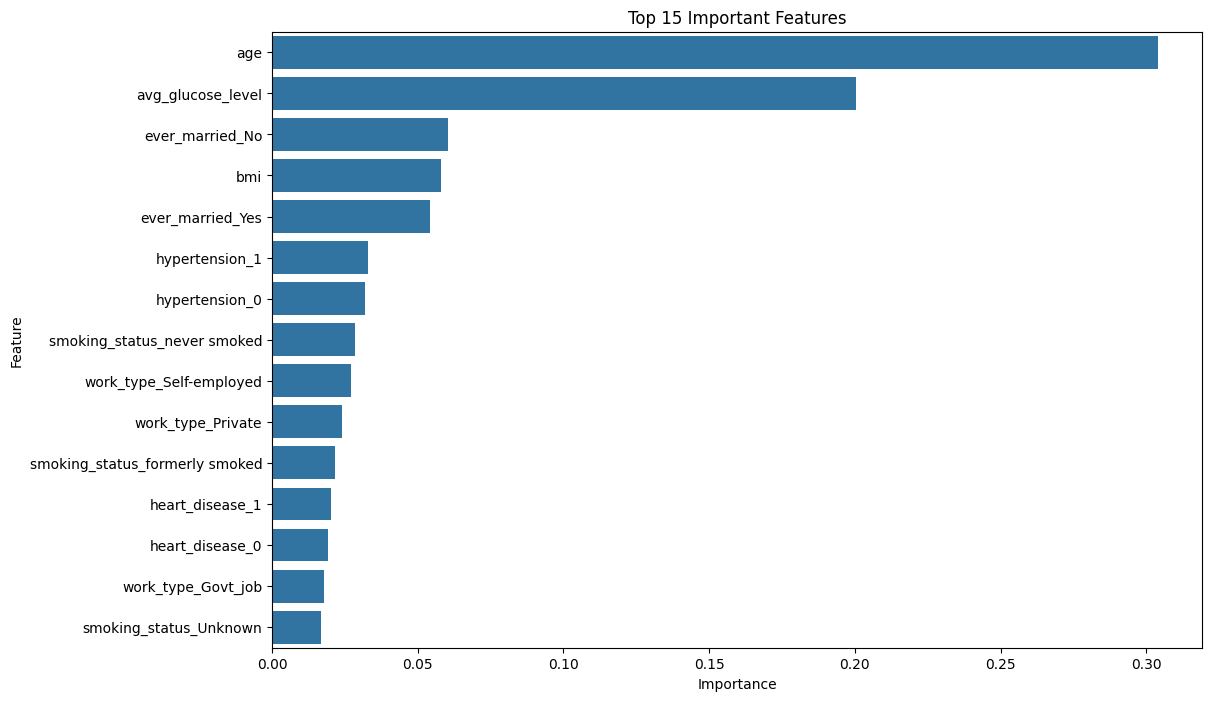


EXAMPLE PREDICTION:
Probability: 0.8875858026094314
Risk_Level: High
Interpretation: High risk of stroke (88.8%)


In [13]:
# ----------------------------------
# STEP 1: SETUP AND DATA LOADING
# ----------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('heart_stroke_data.csv')
print(f"Dataset shape: {df.shape}")
df.head()

# ----------------------------------
# STEP 2: DATA CLEANING AND OUTLIER HANDLING
# ----------------------------------
# Remove ID column
df = df.drop(columns=['id'])

# Define numerical features
numerical_features = ['age', 'avg_glucose_level', 'bmi']

# Outlier handling function
def handle_outliers(df, features):
    df_clean = df.copy()
    for col in features:
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        
        # Cap outliers but preserve stroke cases
        stroke_mask = df_clean['stroke'] == 1
        df_clean.loc[~stroke_mask & (df_clean[col] < lower), col] = lower
        df_clean.loc[~stroke_mask & (df_clean[col] > upper), col] = upper
    return df_clean

df = handle_outliers(df, numerical_features)

# ----------------------------------
# STEP 3: DATA PREPROCESSING
# ----------------------------------
# Define features and target
X = df.drop(columns=['stroke'])
y = df['stroke']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                       'work_type', 'Residence_type', 'smoking_status']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# ----------------------------------
# STEP 4: HANDLE CLASS IMBALANCE WITH SMOTE
# ----------------------------------
# Create pipeline with SMOTE
model_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Verify SMOTE
print("Class distribution before SMOTE:", np.bincount(y_train))
model_pipeline.fit(X_train, y_train)
print("Pipeline fitted successfully!")

# ----------------------------------
# STEP 5: HYPERPARAMETER TUNING
# ----------------------------------
# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': ['balanced', None]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit the model
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed!")

# Get best model
best_model = grid_search.best_estimator_
print("\nBEST PARAMETERS:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)

# ----------------------------------
# STEP 6: EVALUATE FINAL MODEL
# ----------------------------------
# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nFINAL MODEL PERFORMANCE:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance
feature_names = numerical_features + list(
    best_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)

importances = best_model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Important Features')
plt.show()

# ----------------------------------
# STEP 7: PREDICTION FUNCTION
# ----------------------------------
def predict_stroke_risk(input_data):
    """Predicts stroke risk probability (0-1)"""
    input_df = pd.DataFrame([input_data])
    proba = best_model.predict_proba(input_df)[0, 1]
    
    if proba >= 0.7:
        risk = "High"
    elif proba >= 0.4:
        risk = "Medium"
    else:
        risk = "Low"
    
    return {
        'probability': float(proba),
        'risk_level': risk,
        'interpretation': f"{risk} risk of stroke ({proba:.1%})"
    }

# Example usage
example_patient = {
    'gender': 'Male',
    'age': 67,
    'hypertension': 1,
    'heart_disease': 1,
    'ever_married': 'Yes',
    'work_type': 'Private',
    'Residence_type': 'Urban',
    'avg_glucose_level': 228.69,
    'bmi': 36.6,
    'smoking_status': 'formerly smoked'
}

result = predict_stroke_risk(example_patient)
print("\nEXAMPLE PREDICTION:")
for key, value in result.items():
    print(f"{key.title()}: {value}")

In [37]:
import joblib
from datetime import datetime

# Create filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'stroke_prediction_model.pkl'

# Save the best model
joblib.dump(best_model, model_filename)

print(f"Model saved as: {model_filename}")

Model saved as: stroke_prediction_model.pkl


In [38]:
# Load and test the saved model
loaded_model = joblib.load(model_filename)

# Test prediction with example data
test_pred = loaded_model.predict_proba(pd.DataFrame([example_patient]))[0, 1]
print(f"Test prediction from loaded model: {test_pred:.1%}")

Test prediction from loaded model: 88.8%
